# Connect to drive folder

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/dip_learners_folder

Mounted at /gdrive
/gdrive/My Drive/dip_learners_folder


# Import libraries

In [ ]:
seed = 2

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Load the data

In [ ]:
dataset = np.load('public_data.npz', allow_pickle=True)

# dataset contains 2 arrays: data and labels
X = dataset['data']
y = dataset['labels']


In [ ]:
# Count the occurrences of 'healthy' and 'unhealthy'
healthy_count = np.count_nonzero(y == 'healthy')
unhealthy_count = np.count_nonzero(y == 'unhealthy')

print("Count of 'healthy' labels:", healthy_count)
print("Count of 'unhealthy' labels:", unhealthy_count)
print("Percentage of healthy ", healthy_count/5200 )

Count of 'healthy' labels: 3199
Count of 'unhealthy' labels: 2001
Percentage of healthy  0.6151923076923077


# Remove outliers

In [ ]:
## DELETING TROLL IMAGES

# cleaning images from trolls and shreks
shrek = X[58]
troll = X[2150]
shrek_indexes = []
troll_indexes = []
for i in range(0, len(X)):
    shrekDiff = np.mean(np.abs(shrek - X[i]))
    trollDiff = np.mean(np.abs(troll - X[i]))
    if(shrekDiff == 0.0):
        shrek_indexes.append(i)
    elif(trollDiff == 0.0):
        troll_indexes.append(i)

rm_indexes = np.concatenate((shrek_indexes, troll_indexes))

X_clean = np.delete(X, rm_indexes, axis = 0)
y_clean = np.delete(y, rm_indexes, axis = 0)

print('Length of the dataset (images):', len(X_clean))
print('Length of the labels: ', len(y_clean))

## Final result: images + labels

Length of the dataset (images): 5004
Length of the labels:  5004


# Set for training, validation and test

In [ ]:
### Change labels to {0,1}
# healthy = 0, unhealthy = 1

y_clean = (np.array(y_clean) == 'unhealthy').astype(int)

In [ ]:
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_clean, y_clean, random_state=seed, test_size=.20)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test))

# Test data augmentation techniques

### Function to build model

In [ ]:
def build_model_with_augmentation(aug_layer, input_shape):
    tf.random.set_seed(seed)

    input_layer = tfkl.Input(shape=input_shape)

    # Random augmentation layer
    augmentation = aug_layer(input_layer)

    preprocess = preprocess_input(augmentation)

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96,96,3))
    base_model.trainable = False
    resnet_model = base_model(preprocess, training=False)

    pooling_layer = tfkl.GlobalAveragePooling2D()(resnet_model)

    initializer = tf.keras.initializers.GlorotNormal(seed=seed)
    dense = tfkl.Dense(256, activation='relu', kernel_initializer=initializer)(pooling_layer)

    output = tfkl.Dense(1, activation='sigmoid', kernel_initializer=initializer)(dense)


    model = tfk.Model(inputs=input_layer, outputs=output, name='model')

    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy', 'Precision', 'Recall'])

    # Return the model
    return model

### Image flip

In [ ]:
flip_v = tfkl.RandomFlip("vertical")

augmented_model = build_model_with_augmentation(flip_v, X_train.shape[1:])
augmented_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 random_flip (RandomFlip)    (None, 96, 96, 3)         0         
                                                                 
 tf.__operators__.getitem_2  (None, 96, 96, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0     

In [ ]:
history = augmented_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
188/188 [==============================] - 11s 37ms/step - loss: 0.5549 - accuracy: 0.7512 - precision: 0.6868 - recall: 0.6294 - val_loss: 0.4433 - val_accuracy: 0.7882 - val_precision: 0.9153 - val_recall: 0.4688
Epoch 2/200
188/188 [==============================] - 5s 28ms/step - loss: 0.3919 - accuracy: 0.8284 - precision: 0.7988 - recall: 0.7306 - val_loss: 0.4101 - val_accuracy: 0.8082 - val_precision: 0.6863 - val_recall: 0.8835
Epoch 3/200
188/188 [==============================] - 5s 25ms/step - loss: 0.3353 - accuracy: 0.8544 - precision: 0.8282 - recall: 0.7764 - val_loss: 0.4053 - val_accuracy: 0.7962 - val_precision: 0.6960 - val_recall: 0.7940
Epoch 4/200
188/188 [==============================] - 5s 25ms/step - loss: 0.3091 - accuracy: 0.8621 - precision: 0.8324 - recall: 0.7958 - val_loss: 0.3859 - val_accuracy: 0.8192 - val_precision: 0.8052 - val_recall: 0.6721
Epoch 5/200
188/188 [==============================] - 5s 26ms/step - loss: 0.2853 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (augmented_model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 26ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))


Accuracy: 0.8292
Precision: 0.8231
Recall: 0.8181
F1: 0.8203


In [ ]:
augmented_model.save('ResNet_group_model')

### Random brightness

In [ ]:
bright = tfkl.RandomBrightness(0.3, value_range=(0,1))

augmented_model = build_model_with_augmentation(bright, X_train.shape[1:])
augmented_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 random_brightness (RandomB  (None, 96, 96, 3)         0         
 rightness)                                                      
                                                                 
 tf.__operators__.getitem_3  (None, 96, 96, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                             

In [ ]:
history = augmented_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
188/188 [==============================] - 14s 35ms/step - loss: 0.6845 - accuracy: 0.6006 - precision: 0.4103 - recall: 0.1268 - val_loss: 1.3137 - val_accuracy: 0.4156 - val_precision: 0.3583 - val_recall: 0.7398
Epoch 2/200
188/188 [==============================] - 5s 26ms/step - loss: 0.6664 - accuracy: 0.6143 - precision: 0.4599 - recall: 0.1109 - val_loss: 1.9644 - val_accuracy: 0.4006 - val_precision: 0.3655 - val_recall: 0.8509
Epoch 3/200
188/188 [==============================] - 5s 25ms/step - loss: 0.6576 - accuracy: 0.6219 - precision: 0.5024 - recall: 0.0915 - val_loss: 2.4362 - val_accuracy: 0.4046 - val_precision: 0.3709 - val_recall: 0.8835
Epoch 4/200
188/188 [==============================] - 4s 24ms/step - loss: 0.6565 - accuracy: 0.6236 - precision: 0.5075 - recall: 0.1796 - val_loss: 2.6283 - val_accuracy: 0.4046 - val_precision: 0.3726 - val_recall: 0.8997
Epoch 5/200
188/188 [==============================] - 5s 28ms/step - loss: 0.6616 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (augmented_model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 23ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))


Accuracy: 0.3986
Precision: 0.4299
Recall: 0.4406
F1: 0.3906


### Random zoom

In [ ]:
zoom = tfkl.RandomZoom(0.3) # zoom 30%

augmented_model = build_model_with_augmentation(zoom, X_train.shape[1:])
augmented_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 96, 96, 3)         0         
                                                                 
 tf.__operators__.getitem_1  (None, 96, 96, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0     

In [ ]:
history = augmented_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
188/188 [==============================] - 12s 38ms/step - loss: 0.5682 - accuracy: 0.7365 - precision: 0.6693 - recall: 0.6004 - val_loss: 0.4661 - val_accuracy: 0.7862 - val_precision: 0.9058 - val_recall: 0.4688
Epoch 2/200
188/188 [==============================] - 5s 25ms/step - loss: 0.4266 - accuracy: 0.7981 - precision: 0.7568 - recall: 0.6875 - val_loss: 0.3723 - val_accuracy: 0.8222 - val_precision: 0.7520 - val_recall: 0.7724
Epoch 3/200
188/188 [==============================] - 5s 26ms/step - loss: 0.3853 - accuracy: 0.8225 - precision: 0.7852 - recall: 0.7306 - val_loss: 0.3894 - val_accuracy: 0.8052 - val_precision: 0.7314 - val_recall: 0.7453
Epoch 4/200
188/188 [==============================] - 5s 28ms/step - loss: 0.3585 - accuracy: 0.8288 - precision: 0.7917 - recall: 0.7430 - val_loss: 0.3934 - val_accuracy: 0.8142 - val_precision: 0.8303 - val_recall: 0.6233
Epoch 5/200
188/188 [==============================] - 5s 27ms/step - loss: 0.3442 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (augmented_model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 23ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))


Accuracy: 0.8422
Precision: 0.8354
Recall: 0.8348
F1: 0.8351


### Random contrast

In [ ]:
contrast = tfkl.RandomContrast(0.3)

augmented_model = build_model_with_augmentation(contrast, X_train.shape[1:])
augmented_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 random_contrast (RandomCon  (None, 96, 96, 3)         0         
 trast)                                                          
                                                                 
 tf.__operators__.getitem_5  (None, 96, 96, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_5 (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                             

In [ ]:
history = augmented_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
188/188 [==============================] - 11s 35ms/step - loss: 0.5695 - accuracy: 0.7382 - precision: 0.6692 - recall: 0.6092 - val_loss: 0.4153 - val_accuracy: 0.8022 - val_precision: 0.8608 - val_recall: 0.5528
Epoch 2/200
188/188 [==============================] - 5s 27ms/step - loss: 0.3720 - accuracy: 0.8404 - precision: 0.8102 - recall: 0.7553 - val_loss: 0.3862 - val_accuracy: 0.8112 - val_precision: 0.7446 - val_recall: 0.7425
Epoch 3/200
188/188 [==============================] - 5s 28ms/step - loss: 0.3039 - accuracy: 0.8734 - precision: 0.8559 - recall: 0.8002 - val_loss: 0.3815 - val_accuracy: 0.8232 - val_precision: 0.7609 - val_recall: 0.7588
Epoch 4/200
188/188 [==============================] - 5s 25ms/step - loss: 0.2750 - accuracy: 0.8834 - precision: 0.8606 - recall: 0.8257 - val_loss: 0.3702 - val_accuracy: 0.8292 - val_precision: 0.8214 - val_recall: 0.6856
Epoch 5/200
188/188 [==============================] - 5s 27ms/step - loss: 0.2309 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (augmented_model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 25ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))


Accuracy: 0.8272
Precision: 0.8195
Recall: 0.8198
F1: 0.8197


### Random flip + random zoom

In [ ]:
aug_layers = tf.keras.Sequential([
  tfkl.RandomFlip("vertical"),
  tfkl.RandomZoom(0.3),
])

augmented_model = build_model_with_augmentation(aug_layers, X_train.shape[1:])
augmented_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 tf.__operators__.getitem (  (None, 96, 96, 3)         0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 96, 96, 3)         0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                              

In [ ]:
history = augmented_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
188/188 [==============================] - 25s 43ms/step - loss: 0.5972 - accuracy: 0.7318 - precision: 0.6611 - recall: 0.5977 - val_loss: 0.4461 - val_accuracy: 0.7802 - val_precision: 0.8531 - val_recall: 0.4878
Epoch 2/200
188/188 [==============================] - 5s 25ms/step - loss: 0.4389 - accuracy: 0.7925 - precision: 0.7493 - recall: 0.6787 - val_loss: 0.3802 - val_accuracy: 0.8132 - val_precision: 0.7370 - val_recall: 0.7669
Epoch 3/200
188/188 [==============================] - 5s 26ms/step - loss: 0.4182 - accuracy: 0.8065 - precision: 0.7707 - recall: 0.6954 - val_loss: 0.4097 - val_accuracy: 0.7952 - val_precision: 0.6839 - val_recall: 0.8266
Epoch 4/200
188/188 [==============================] - 5s 28ms/step - loss: 0.3920 - accuracy: 0.8251 - precision: 0.7879 - recall: 0.7359 - val_loss: 0.4040 - val_accuracy: 0.8102 - val_precision: 0.8185 - val_recall: 0.6233
Epoch 5/200
188/188 [==============================] - 5s 27ms/step - loss: 0.3739 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (augmented_model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 1s 25ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8492
Precision: 0.8449
Recall: 0.8381
F1: 0.841


In [ ]:
# Save the trained model
augmented_model.save('augmented_model.keras')

### Random flip + random contrast

In [ ]:
aug_layers = tf.keras.Sequential([
  tfkl.RandomFlip("vertical"),
  tfkl.RandomContrast(0.3),
])

augmented_model = build_model_with_augmentation(aug_layers, X_train.shape[1:])
augmented_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 tf.__operators__.getitem_7  (None, 96, 96, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_7 (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0     

In [ ]:
history = augmented_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
188/188 [==============================] - 11s 35ms/step - loss: 0.5704 - accuracy: 0.7412 - precision: 0.6738 - recall: 0.6127 - val_loss: 0.4193 - val_accuracy: 0.7982 - val_precision: 0.8327 - val_recall: 0.5664
Epoch 2/200
188/188 [==============================] - 5s 26ms/step - loss: 0.4047 - accuracy: 0.8245 - precision: 0.7925 - recall: 0.7262 - val_loss: 0.4318 - val_accuracy: 0.7902 - val_precision: 0.6667 - val_recall: 0.8618
Epoch 3/200
188/188 [==============================] - 5s 28ms/step - loss: 0.3612 - accuracy: 0.8378 - precision: 0.8053 - recall: 0.7535 - val_loss: 0.4176 - val_accuracy: 0.8052 - val_precision: 0.6908 - val_recall: 0.8537
Epoch 4/200
188/188 [==============================] - 5s 26ms/step - loss: 0.3302 - accuracy: 0.8551 - precision: 0.8260 - recall: 0.7817 - val_loss: 0.3702 - val_accuracy: 0.8232 - val_precision: 0.8137 - val_recall: 0.6748
Epoch 5/200
188/188 [==============================] - 5s 27ms/step - loss: 0.3123 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (augmented_model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 26ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8382
Precision: 0.8311
Recall: 0.8311
F1: 0.8311


### Contrast + zoom

In [ ]:
aug_layers = tf.keras.Sequential([
  tfkl.RandomContrast(0.3),
  tfkl.RandomZoom(0.3),
])

augmented_model = build_model_with_augmentation(aug_layers, X_train.shape[1:])
augmented_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 tf.__operators__.getitem_8  (None, 96, 96, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_8 (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0     

In [ ]:
history = augmented_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
188/188 [==============================] - 10s 37ms/step - loss: 0.5907 - accuracy: 0.7308 - precision: 0.6583 - recall: 0.6004 - val_loss: 0.4241 - val_accuracy: 0.7982 - val_precision: 0.8036 - val_recall: 0.5989
Epoch 2/200
188/188 [==============================] - 5s 27ms/step - loss: 0.4438 - accuracy: 0.7948 - precision: 0.7534 - recall: 0.6805 - val_loss: 0.4313 - val_accuracy: 0.7912 - val_precision: 0.6990 - val_recall: 0.7615
Epoch 3/200
188/188 [==============================] - 5s 26ms/step - loss: 0.4095 - accuracy: 0.8131 - precision: 0.7741 - recall: 0.7148 - val_loss: 0.3987 - val_accuracy: 0.8112 - val_precision: 0.7795 - val_recall: 0.6802
Epoch 4/200
188/188 [==============================] - 6s 30ms/step - loss: 0.3707 - accuracy: 0.8354 - precision: 0.8006 - recall: 0.7526 - val_loss: 0.3906 - val_accuracy: 0.8272 - val_precision: 0.8427 - val_recall: 0.6531
Epoch 5/200
188/188 [==============================] - 5s 27ms/step - loss: 0.3641 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (augmented_model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 26ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8352
Precision: 0.8272
Recall: 0.8333
F1: 0.8297


### Flip + contrast + zoom

In [ ]:
aug_layers = tf.keras.Sequential([
  tfkl.RandomFlip("vertical"),
  tfkl.RandomContrast(0.3),
  tfkl.RandomZoom(0.3),
])

augmented_model = build_model_with_augmentation(aug_layers, X_train.shape[1:])
augmented_model.summary()

NameError: ignored

In [ ]:
history = augmented_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
188/188 [==============================] - 12s 37ms/step - loss: 0.5833 - accuracy: 0.7278 - precision: 0.6633 - recall: 0.5704 - val_loss: 0.4190 - val_accuracy: 0.8012 - val_precision: 0.8295 - val_recall: 0.5799
Epoch 2/200
188/188 [==============================] - 5s 28ms/step - loss: 0.4460 - accuracy: 0.7931 - precision: 0.7567 - recall: 0.6681 - val_loss: 0.3915 - val_accuracy: 0.8162 - val_precision: 0.7829 - val_recall: 0.6938
Epoch 3/200
188/188 [==============================] - 5s 27ms/step - loss: 0.4215 - accuracy: 0.8065 - precision: 0.7645 - recall: 0.7060 - val_loss: 0.4048 - val_accuracy: 0.8022 - val_precision: 0.7382 - val_recall: 0.7182
Epoch 4/200
188/188 [==============================] - 5s 26ms/step - loss: 0.4080 - accuracy: 0.8098 - precision: 0.7658 - recall: 0.7165 - val_loss: 0.3999 - val_accuracy: 0.8102 - val_precision: 0.8482 - val_recall: 0.5908
Epoch 5/200
188/188 [==============================] - 6s 31ms/step - loss: 0.4003 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (augmented_model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 26ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8342
Precision: 0.8263
Recall: 0.8299
F1: 0.8279


#Data augmentation: generate new images

In [ ]:
# Creazione di un oggetto ImageDataGenerator con le tecniche di augmentation
datagen = ImageDataGenerator(
    zoom_range=0.3,
    vertical_flip=True,
    fill_mode='nearest'
)

# Caricamento delle immagini originali e generazione di nuove immagini aumentate
X_train_aug = []
y_train_aug = []

for i in range(len(X_train)):
    original_image = X_train[i]
    image_label = y_train[i]

    X_train_aug.append(original_image)
    y_train_aug.append(image_label)

    #for _ in range(1):  # Genera 1 versione aumentata per ciascuna immagine
    #batch = datagen_zoom.flow(np.expand_dims(original_image, axis=0))
    #augmented_image = batch[0][0]
    #X_train_aug.append(augmented_image)
    #y_train_aug.append(image_label)

    batch = datagen.flow(np.expand_dims(original_image, axis=0))
    augmented_image = batch[0][0]
    X_train_aug.append(augmented_image)
    y_train_aug.append(image_label)



X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

print(X_train_aug.shape)
print(y_train_aug.shape)

view_random_data(X_train_aug,y_train_aug)


# Train ResNet50 on augmented train data

In [ ]:
aug_layers = tf.keras.Sequential([
  tfkl.RandomFlip("vertical"),
  tfkl.RandomZoom(0.3),
])

augmented_model = build_model_with_augmentation(aug_layers, X_train_aug.shape[1:])
augmented_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 sequential_4 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 tf.__operators__.getitem_1  (None, 96, 96, 3)         0         
 0 (SlicingOpLambda)                                             
                                                                 
 tf.nn.bias_add_10 (TFOpLam  (None, 96, 96, 3)         0         
 bda)                                                            
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0     

In [ ]:
history = model.fit(
    X_train_aug,
    y_train_aug,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
376/376 [==============================] - 17s 29ms/step - loss: 0.5236 - accuracy: 0.7578 - precision: 0.6974 - recall: 0.6360 - val_loss: 0.4103 - val_accuracy: 0.8152 - val_precision: 0.7754 - val_recall: 0.7019
Epoch 2/200
376/376 [==============================] - 8s 21ms/step - loss: 0.3718 - accuracy: 0.8309 - precision: 0.7991 - recall: 0.7390 - val_loss: 0.3926 - val_accuracy: 0.8192 - val_precision: 0.7901 - val_recall: 0.6938
Epoch 3/200
376/376 [==============================] - 8s 23ms/step - loss: 0.3069 - accuracy: 0.8668 - precision: 0.8442 - recall: 0.7945 - val_loss: 0.3994 - val_accuracy: 0.8292 - val_precision: 0.7861 - val_recall: 0.7371
Epoch 4/200
376/376 [==============================] - 8s 23ms/step - loss: 0.2434 - accuracy: 0.9004 - precision: 0.8777 - recall: 0.8561 - val_loss: 0.4176 - val_accuracy: 0.8332 - val_precision: 0.8117 - val_recall: 0.7127
Epoch 5/200
376/376 [==============================] - 8s 20ms/step - loss: 0.1811 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 26ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.7992
Precision: 0.7904
Recall: 0.7902
F1: 0.7903


In [ ]:
nClass1 = 0
for i in range(len(predictions_aug)):
  if predictions_aug[i]<0.5:
    print(predictions_aug[i])
    nClass1=nClass1+1
print(nClass1)

In [ ]:
#del X, X_val, X_train, X_train_val, X_train_aug

Il modello sembra troppo semplice, proviamo ad aggiungere qualche dense layer e diminuire la regularation

## Imagenet try 2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

model = tfk.Sequential([
    base_model,
    tfkl.Flatten(),
    tfkl.Dense(2048, activation='relu', kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.3),
    tfkl.Dense(512, activation='relu', kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.2),
    tfkl.Dense(256, activation='relu', kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 flatten_10 (Flatten)        (None, 11520)             0         
                                                                 
 dense_41 (Dense)            (None, 2048)              23595008  
                                                                 
 dropout_13 (Dropout)        (None, 2048)              0         
                                                                 
 dense_42 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                      

In [ ]:
### Fit the model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True)]
)

Epoch 1/200
94/94 [==============================] - 8s 50ms/step - loss: 11.7069 - accuracy: 0.5753 - val_loss: 4.5373 - val_accuracy: 0.6314
Epoch 2/200
94/94 [==============================] - 3s 28ms/step - loss: 3.3921 - accuracy: 0.6352 - val_loss: 2.5846 - val_accuracy: 0.6394
Epoch 3/200
94/94 [==============================] - 3s 30ms/step - loss: 2.1934 - accuracy: 0.6272 - val_loss: 1.8368 - val_accuracy: 0.6643
Epoch 4/200
94/94 [==============================] - 3s 29ms/step - loss: 1.6694 - accuracy: 0.6396 - val_loss: 1.4864 - val_accuracy: 0.6414
Epoch 5/200
94/94 [==============================] - 3s 27ms/step - loss: 1.3721 - accuracy: 0.6316 - val_loss: 1.2459 - val_accuracy: 0.6384
Epoch 6/200
94/94 [==============================] - 3s 34ms/step - loss: 1.1823 - accuracy: 0.6429 - val_loss: 1.1123 - val_accuracy: 0.6813
Epoch 7/200
94/94 [==============================] - 3s 29ms/step - loss: 1.0557 - accuracy: 0.6336 - val_loss: 0.9768 - val_accuracy: 0.6464
Epoch

In [ ]:
# Predict labels for the entire test set
predictions = (model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 1s 14ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.6813
Precision: 0.6659
Recall: 0.6616
F1: 0.6632


# Convnext

In [ ]:
base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

model = tfk.Sequential([
    base_model,
    tfkl.Flatten(),
    tfkl.Dense(1024, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.5),
    tfkl.Dense(512, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.3),
    tfkl.Dense(256, activation='relu', kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

350926856/350926856 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 3, 3, 1024)        87566464  
                                                                 
 flatten_11 (Flatten)        (None, 9216)              0         
                                                                 
 dense_45 (Dense)            (None, 1024)              9438208   
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_46 (Dense)            (None, 512)               524800    
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_47 (Dense)            (None, 256)             

In [ ]:
### Fit the model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
)

Epoch 1/200
94/94 [==============================] - 64s 438ms/step - loss: 14.9987 - accuracy: 0.6326 - val_loss: 6.8045 - val_accuracy: 0.7932
Epoch 2/200
94/94 [==============================] - 17s 183ms/step - loss: 4.9520 - accuracy: 0.7612 - val_loss: 3.6390 - val_accuracy: 0.7962
Epoch 3/200
94/94 [==============================] - 18s 193ms/step - loss: 3.0936 - accuracy: 0.7648 - val_loss: 2.5151 - val_accuracy: 0.8362
Epoch 4/200
94/94 [==============================] - 16s 176ms/step - loss: 2.2102 - accuracy: 0.7938 - val_loss: 1.8507 - val_accuracy: 0.8222
Epoch 5/200
94/94 [==============================] - 16s 175ms/step - loss: 1.7225 - accuracy: 0.7885 - val_loss: 1.4893 - val_accuracy: 0.8022
Epoch 6/200
94/94 [==============================] - 17s 177ms/step - loss: 1.3986 - accuracy: 0.7985 - val_loss: 1.2604 - val_accuracy: 0.8272
Epoch 7/200
94/94 [==============================] - 17s 179ms/step - loss: 1.1649 - accuracy: 0.7975 - val_loss: 1.1039 - val_accuracy

In [ ]:
# Predict labels for the entire test set
predictions = (model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 8s 136ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8302
Precision: 0.8287
Recall: 0.8129
F1: 0.8188


In [ ]:
model.save('Bre11Nov')

Il modello sembra promettente, possiamo andare avanti con questo :)
Non c'è overfitting per cui possiamo aggiungere complessità e vedere come performerà

## ConvexNet Test 2

Prima proviamo senza centered mean: channel_means diverso da 0

In [ ]:
channel_means = np.mean(X_train,axis=(0,1,2)) #mistery
channel_means

array([ 86.79208, 124.18411,  66.44425], dtype=float32)

Usiamo prima lo stesso modello, per vedere se migliorava solo centrando il dataset

In [ ]:
base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

model = tfk.Sequential([
    base_model,
    tfkl.Flatten(),
    tfkl.Dense(1024, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.5),
    tfkl.Dense(512, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.3),
    tfkl.Dense(256, activation='relu', kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

350926856/350926856 [==============================] - 7s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 3, 3, 1024)        87566464  
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 1024)              9438208   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               1

In [ ]:
### Fit the model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
)

Epoch 1/200
94/94 [==============================] - 96s 538ms/step - loss: 13.9753 - accuracy: 0.6476 - val_loss: 5.8829 - val_accuracy: 0.7782
Epoch 2/200
94/94 [==============================] - 19s 206ms/step - loss: 4.2319 - accuracy: 0.7602 - val_loss: 3.0736 - val_accuracy: 0.8122
Epoch 3/200
94/94 [==============================] - 18s 196ms/step - loss: 2.5918 - accuracy: 0.7928 - val_loss: 2.1144 - val_accuracy: 0.8052
Epoch 4/200
94/94 [==============================] - 24s 254ms/step - loss: 1.8869 - accuracy: 0.7955 - val_loss: 1.6646 - val_accuracy: 0.8032
Epoch 5/200
94/94 [==============================] - 17s 179ms/step - loss: 1.4976 - accuracy: 0.7875 - val_loss: 1.2456 - val_accuracy: 0.8122
Epoch 6/200
94/94 [==============================] - 16s 176ms/step - loss: 1.2009 - accuracy: 0.7925 - val_loss: 1.0754 - val_accuracy: 0.7822
Epoch 7/200
94/94 [==============================] - 18s 195ms/step - loss: 1.0153 - accuracy: 0.7931 - val_loss: 0.8824 - val_accuracy

Test set:

In [ ]:
# Predict labels for the entire test set
predictions = (model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 9s 121ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8272
Precision: 0.8288
Recall: 0.8066
F1: 0.814


Proviamo a trainare nuovamente il modello, notiamo che aumenta l'accuracy. Questo forse significa che vogliamo più epochs, e quindi dobbiamo aumentare la patience

In [ ]:
### Fit the model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
)

Epoch 1/200
94/94 [==============================] - 17s 185ms/step - loss: 0.8417 - accuracy: 0.8354 - val_loss: 0.8842 - val_accuracy: 0.8392
Epoch 2/200
94/94 [==============================] - 17s 182ms/step - loss: 0.8668 - accuracy: 0.8428 - val_loss: 0.7299 - val_accuracy: 0.8591
Epoch 3/200
94/94 [==============================] - 17s 179ms/step - loss: 0.7459 - accuracy: 0.8454 - val_loss: 0.6633 - val_accuracy: 0.8392
Epoch 4/200
94/94 [==============================] - 17s 179ms/step - loss: 0.6749 - accuracy: 0.8451 - val_loss: 0.6570 - val_accuracy: 0.8561
Epoch 5/200
94/94 [==============================] - 18s 188ms/step - loss: 0.6542 - accuracy: 0.8514 - val_loss: 0.6904 - val_accuracy: 0.8302
Epoch 6/200
94/94 [==============================] - 17s 178ms/step - loss: 0.6394 - accuracy: 0.8574 - val_loss: 0.6157 - val_accuracy: 0.8501
Epoch 7/200
94/94 [==============================] - 17s 180ms/step - loss: 0.6465 - accuracy: 0.8541 - val_loss: 0.6212 - val_accuracy:

Test set:

In [ ]:
# Predict labels for the entire test set
predictions = (model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 5s 158ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8322
Precision: 0.8352
Recall: 0.8112
F1: 0.8191


In [ ]:
model.save('bre11nov2')

### Proviamo in un altro modo: aumentiamo la complessità

Come possiamo migliorare il modello? Proviamo aumentando la complessità, ma sempre tenendo a bada l'overfitting. Duplichiamo il numero di neuroni del primo e del secondo dense layer. Diminuiamo il valore dei layer di dropout.

In [ ]:
base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

modelMoreComplex = tfk.Sequential([
    base_model,
    tfkl.Flatten(),
    tfkl.Dense(2048, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.3),
    tfkl.Dense(1024, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.2),
    tfkl.Dense(256, activation='relu', kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dense(1, activation='sigmoid')
])

modelMoreComplex.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = modelMoreComplex.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
)

Epoch 1/200
94/94 [==============================] - 48s 316ms/step - loss: 19.2599 - accuracy: 0.7062 - val_loss: 5.9892 - val_accuracy: 0.8032
Epoch 2/200
94/94 [==============================] - 17s 185ms/step - loss: 4.1718 - accuracy: 0.7915 - val_loss: 2.9239 - val_accuracy: 0.8282
Epoch 3/200
94/94 [==============================] - 17s 182ms/step - loss: 2.4003 - accuracy: 0.8091 - val_loss: 2.0495 - val_accuracy: 0.7592
Epoch 4/200
94/94 [==============================] - 18s 195ms/step - loss: 1.6602 - accuracy: 0.8185 - val_loss: 1.7444 - val_accuracy: 0.7113
Epoch 5/200
94/94 [==============================] - 18s 193ms/step - loss: 1.2944 - accuracy: 0.8271 - val_loss: 1.1748 - val_accuracy: 0.8062
Epoch 6/200
94/94 [==============================] - 17s 184ms/step - loss: 1.0476 - accuracy: 0.8281 - val_loss: 0.9536 - val_accuracy: 0.8372
Epoch 7/200
94/94 [==============================] - 18s 197ms/step - loss: 0.9155 - accuracy: 0.8338 - val_loss: 0.8620 - val_accuracy

Test set:

In [ ]:
# Predict labels for the entire test set
predictions = (modelMoreComplex.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 8s 123ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8362
Precision: 0.8386
Recall: 0.8162
F1: 0.8238


# Bre 12 Novembre

Continuiamo a provare ConvexNext, aumentando la complessità

In [ ]:
base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

model = tfk.Sequential([
    base_model,
    tfkl.Flatten(),
    tfkl.Dense(2048, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dense(1024, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.5),
    tfkl.Dense(512, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.3),
    tfkl.Dense(256, activation='relu', kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 3, 3, 1024)        87566464  
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_5 (Dense)             (None, 2048)              18876416  
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)              

In [ ]:
### Fit the model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
)

Epoch 1/200
94/94 [==============================] - 61s 444ms/step - loss: 20.9472 - accuracy: 0.6476 - val_loss: 6.9482 - val_accuracy: 0.8132
Epoch 2/200
94/94 [==============================] - 18s 190ms/step - loss: 5.0649 - accuracy: 0.8031 - val_loss: 3.6522 - val_accuracy: 0.8492
Epoch 3/200
94/94 [==============================] - 18s 194ms/step - loss: 2.9682 - accuracy: 0.8411 - val_loss: 2.3262 - val_accuracy: 0.8482
Epoch 4/200
94/94 [==============================] - 17s 187ms/step - loss: 1.9654 - accuracy: 0.8608 - val_loss: 1.7920 - val_accuracy: 0.7962
Epoch 5/200
94/94 [==============================] - 17s 183ms/step - loss: 1.3798 - accuracy: 0.8831 - val_loss: 1.2761 - val_accuracy: 0.8402
Epoch 6/200
94/94 [==============================] - 18s 196ms/step - loss: 1.0452 - accuracy: 0.8891 - val_loss: 1.0780 - val_accuracy: 0.8302
Epoch 7/200
94/94 [==============================] - 18s 196ms/step - loss: 0.8198 - accuracy: 0.9064 - val_loss: 0.9139 - val_accuracy

Test set:

In [ ]:
# Predict labels for the entire test set
predictions = (model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 7s 129ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8312
Precision: 0.8265
Recall: 0.818
F1: 0.8216


The model seems too complex. Let's add a Dropout layer after the first dense layer!

In [ ]:
base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

model = tfk.Sequential([
    base_model,
    tfkl.Flatten(),
    tfkl.Dense(2048, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.5),
    tfkl.Dense(1024, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.5),
    tfkl.Dense(512, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.3),
    tfkl.Dense(256, activation='relu', kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 3, 3, 1024)        87566464  
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_10 (Dense)            (None, 2048)              18876416  
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 512)              

In [ ]:
### Fit the model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
)

Epoch 1/200
94/94 [==============================] - 58s 399ms/step - loss: 27.0581 - accuracy: 0.6252 - val_loss: 12.3019 - val_accuracy: 0.6943
Epoch 2/200
94/94 [==============================] - 18s 187ms/step - loss: 9.0520 - accuracy: 0.7618 - val_loss: 6.9335 - val_accuracy: 0.7972
Epoch 3/200
94/94 [==============================] - 18s 187ms/step - loss: 5.7727 - accuracy: 0.7825 - val_loss: 4.7532 - val_accuracy: 0.8292
Epoch 4/200
94/94 [==============================] - 18s 192ms/step - loss: 4.0953 - accuracy: 0.7732 - val_loss: 3.4179 - val_accuracy: 0.8272
Epoch 5/200
94/94 [==============================] - 18s 193ms/step - loss: 3.0368 - accuracy: 0.7855 - val_loss: 2.6292 - val_accuracy: 0.7842
Epoch 6/200
94/94 [==============================] - 18s 194ms/step - loss: 2.3336 - accuracy: 0.7851 - val_loss: 2.1807 - val_accuracy: 0.6713
Epoch 7/200
94/94 [==============================] - 17s 180ms/step - loss: 1.8659 - accuracy: 0.7761 - val_loss: 1.6668 - val_accurac

Test set:

In [ ]:
# Predict labels for the entire test set
predictions = (model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

In [ ]:

# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
print(np.sum(y_val == 0)/len(y_val))

0.6313686313686314


In [ ]:
print(np.sum(y_train == 0)/len(y_train))

0.6215856095936043


In [ ]:
print(np.sum(y_test == 0)/len(y_test))

0.6023976023976024


In [ ]:
print(np.sum(y_clean == 0)/len(y_clean))

0.6197042366107114


We can do better, let's make some tuning

In [ ]:
base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

model = tfk.Sequential([
    base_model,
    tfkl.Flatten(),
    tfkl.Dense(2048, activation=tfkl.LeakyReLU(alpha=0.01) ),
    tfkl.Dropout(0.3),
    tfkl.Dense(1024, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.5),
    tfkl.Dense(512, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.3),
    tfkl.Dense(256, activation='relu', kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

350926856/350926856 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 3, 3, 1024)        87566464  
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 2048)              18876416  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               5

In [ ]:
### Fit the model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
94/94 [==============================] - 82s 459ms/step - loss: 13.7519 - accuracy: 0.6219 - val_loss: 7.8368 - val_accuracy: 0.7972
Epoch 2/200
94/94 [==============================] - 18s 191ms/step - loss: 5.9979 - accuracy: 0.8191 - val_loss: 4.5464 - val_accuracy: 0.8272
Epoch 3/200
94/94 [==============================] - 17s 180ms/step - loss: 3.6398 - accuracy: 0.8514 - val_loss: 2.9310 - val_accuracy: 0.8302
Epoch 4/200
94/94 [==============================] - 19s 207ms/step - loss: 2.3578 - accuracy: 0.8871 - val_loss: 1.9977 - val_accuracy: 0.8721
Epoch 5/200
94/94 [==============================] - 18s 195ms/step - loss: 1.6235 - accuracy: 0.9027 - val_loss: 1.4803 - val_accuracy: 0.8571
Epoch 6/200
94/94 [==============================] - 17s 179ms/step - loss: 1.1472 - accuracy: 0.9231 - val_loss: 1.1190 - val_accuracy: 0.8601
Epoch 7/200
94/94 [==============================] - 18s 195ms/step - loss: 0.8234 - accuracy: 0.9367 - val_loss: 0.9006 - val_accuracy

Test set:

In [ ]:
# Predict labels for the entire test set
predictions = (model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 9s 125ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8472
Precision: 0.842
Recall: 0.8373
F1: 0.8394


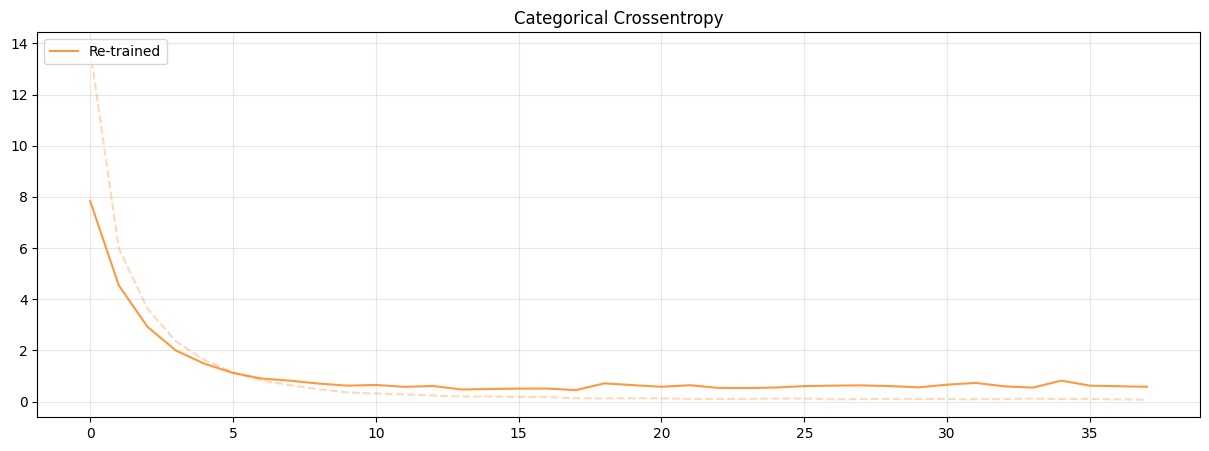

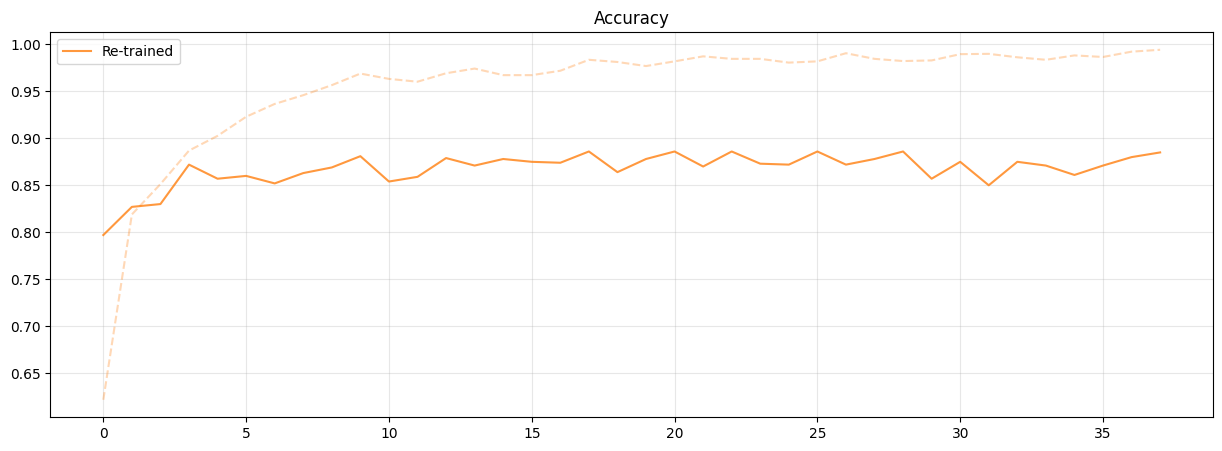

In [ ]:

# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### previous model but with nadam and batch norm

In [ ]:
base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

model = tfk.Sequential([
    base_model,
    tfkl.Flatten(),
    tfkl.Dense(2048, activation=tfkl.LeakyReLU(alpha=0.01) ),
    tfkl.Dropout(0.3),
    tfkl.BatchNormalization(),
    tfkl.Dense(1024, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.5),
    tfkl.BatchNormalization(),
    tfkl.Dense(512, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.3),
    tfkl.BatchNormalization(),
    tfkl.Dense(256, activation='relu', kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])

In [ ]:
### Fit the model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
94/94 [==============================] - 57s 339ms/step - loss: 15.8411 - accuracy: 0.7239 - val_loss: 8.7615 - val_accuracy: 0.7872
Epoch 2/200
94/94 [==============================] - 17s 186ms/step - loss: 5.3383 - accuracy: 0.8288 - val_loss: 3.2052 - val_accuracy: 0.8182
Epoch 3/200
94/94 [==============================] - 18s 188ms/step - loss: 2.2604 - accuracy: 0.8561 - val_loss: 1.7358 - val_accuracy: 0.8242
Epoch 4/200
94/94 [==============================] - 19s 200ms/step - loss: 1.3181 - accuracy: 0.8781 - val_loss: 1.1391 - val_accuracy: 0.8611
Epoch 5/200
94/94 [==============================] - 18s 196ms/step - loss: 1.0097 - accuracy: 0.8897 - val_loss: 1.0197 - val_accuracy: 0.8541
Epoch 6/200
94/94 [==============================] - 19s 198ms/step - loss: 0.9498 - accuracy: 0.8967 - val_loss: 1.1014 - val_accuracy: 0.8402
Epoch 7/200
94/94 [==============================] - 17s 183ms/step - loss: 0.8917 - accuracy: 0.9107 - val_loss: 1.0340 - val_accuracy

In [ ]:
# Predict labels for the entire test set
predictions = (model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 8s 138ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8322
Precision: 0.8287
Recall: 0.8176
F1: 0.822


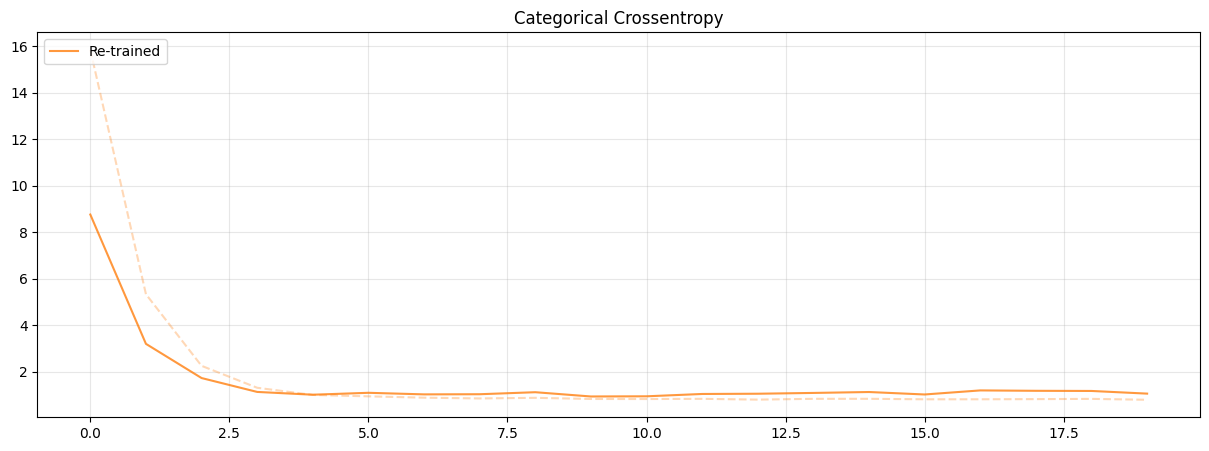

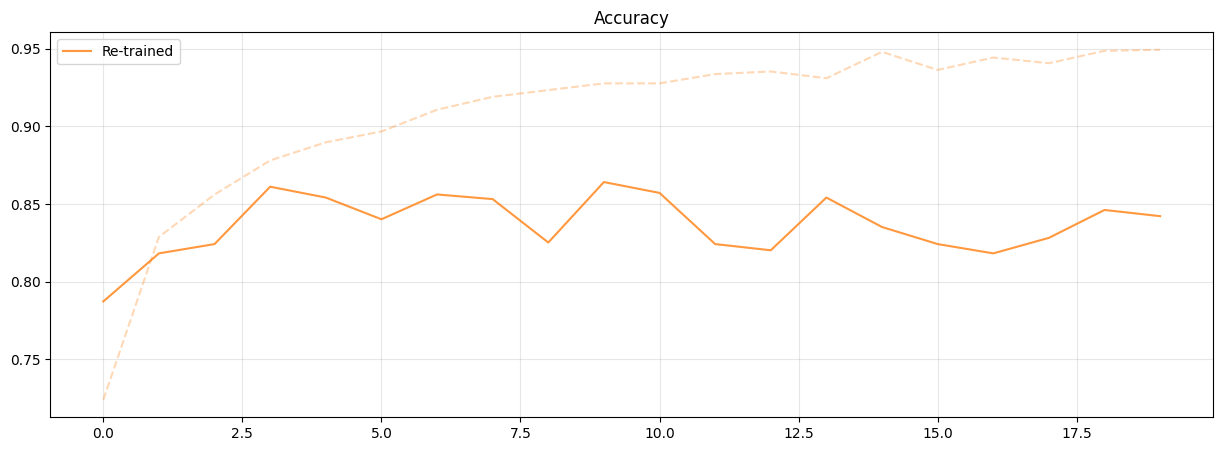

In [ ]:

# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
model.save('bre12novFinale')

# ConvexNext Large
Proviamo la versione large per capire cosa succede

In [ ]:
base_model = tf.keras.applications.ConvNeXtLarge(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

model = tfk.Sequential([
    base_model,
    tfkl.Flatten(),
    tfkl.Dense(2048, activation=tfkl.LeakyReLU(alpha=0.01) ),
    tfkl.Dropout(0.3),
    tfkl.Dense(1024, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.5),
    tfkl.Dense(512, activation=tfkl.LeakyReLU(alpha=0.01), kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dropout(0.3),
    tfkl.Dense(256, activation='relu', kernel_regularizer=tfk.regularizers.l2(0.01)),
    tfkl.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

785596384/785596384 [==============================] - 8s 0us/step


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_large (Functional  (None, 3, 3, 1536)        196230336 
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 13824)             0         
                                                                 
 dense_5 (Dense)             (None, 2048)              28313600  
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                      

In [ ]:
### Fit the model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
)

Epoch 1/200
94/94 [==============================] - 67s 493ms/step - loss: 14.9366 - accuracy: 0.6149 - val_loss: 9.2208 - val_accuracy: 0.7063
Epoch 2/200
94/94 [==============================] - 32s 339ms/step - loss: 7.3128 - accuracy: 0.8111 - val_loss: 5.7523 - val_accuracy: 0.8561
Epoch 3/200
94/94 [==============================] - 33s 347ms/step - loss: 4.8224 - accuracy: 0.8531 - val_loss: 3.9972 - val_accuracy: 0.8631
Epoch 4/200
94/94 [==============================] - 28s 293ms/step - loss: 3.3267 - accuracy: 0.8931 - val_loss: 2.9353 - val_accuracy: 0.8452
Epoch 5/200
94/94 [==============================] - 31s 332ms/step - loss: 2.4050 - accuracy: 0.9171 - val_loss: 2.2022 - val_accuracy: 0.8432
Epoch 6/200
94/94 [==============================] - 32s 339ms/step - loss: 1.7571 - accuracy: 0.9347 - val_loss: 1.6497 - val_accuracy: 0.8781
Epoch 7/200
94/94 [==============================] - 31s 332ms/step - loss: 1.3174 - accuracy: 0.9410 - val_loss: 1.3896 - val_accuracy

Test set:

In [ ]:
# Predict labels for the entire test set
predictions = (model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 11s 206ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8601
Precision: 0.8574
Recall: 0.8485
F1: 0.8523
